In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
sys.path.append("..")
from wishart import wishart_lib, wishart_lib_stepan
from motifs import motifs
from indexes import indexes_lib
from generator import generator_lib
import numpy as np
from matplotlib import pyplot as plt
import importlib
from scipy.interpolate import make_interp_spline, BSpline

import sys
sys.path.append("..")
importlib.reload(wishart_lib_stepan)
importlib.reload(wishart_lib)
importlib.reload(indexes_lib)
importlib.reload(generator_lib)
importlib.reload(motifs)

from collections import defaultdict
from motifs.motifs import GenerateAllMotifs, GenPatterns
import numpy as np
import pdb
import dill
# from sklearn.datasets.samples_generator import make_blobs
import random
from itertools import combinations, product
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform, euclidean
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
from math import sqrt
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score
import seaborn as sn

In [31]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    #Differential equations of a Lorenz System
    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    #RK4 for the differential equations
    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        #Initial values and Parameters
        x_0, y_0, z_0 = 1, 1, 1

        #RK4 iteration
        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [32]:
lorents = Lorentz()
data, _, _ = Lorentz().generate(0.1, 100000)
data = data[250:]
data = (data - data.min()) / (data.max() - data.min())

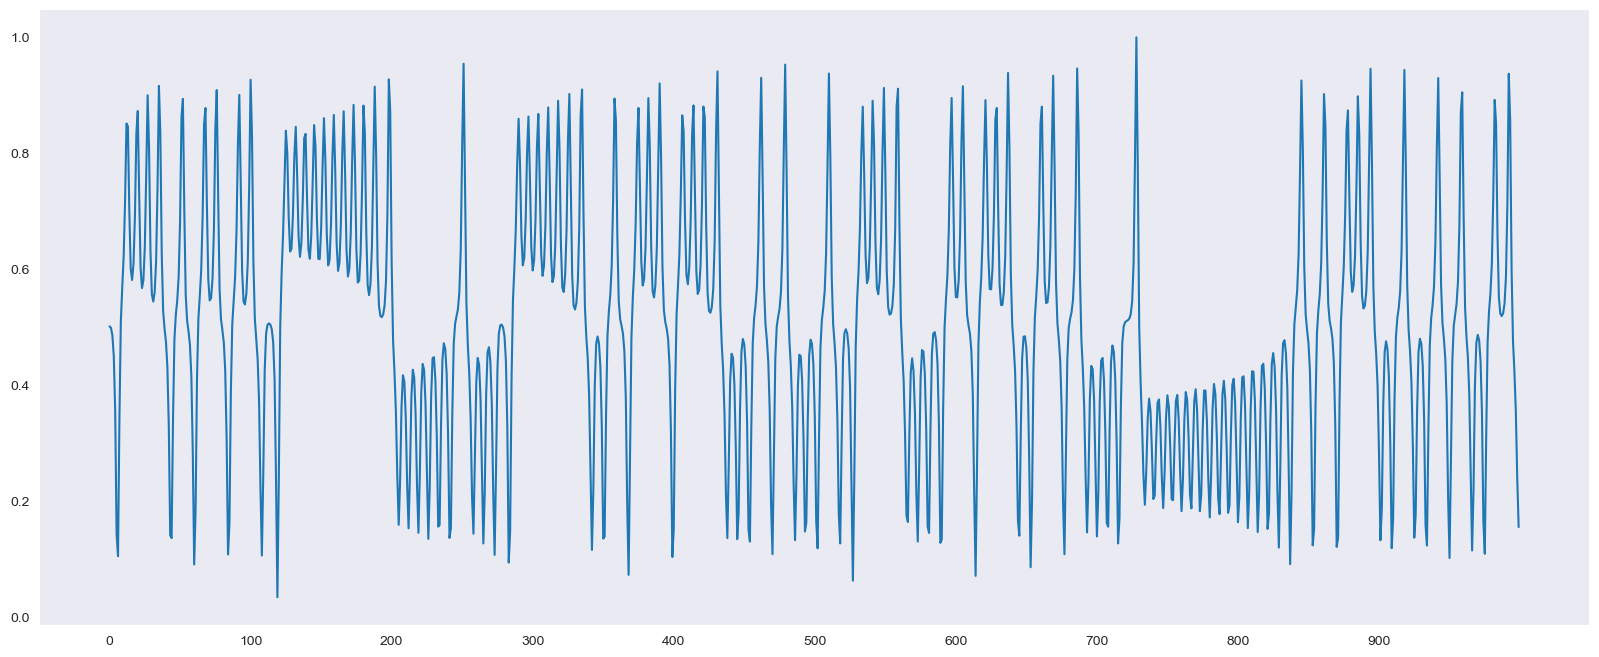

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(data[:1000])
plt.xticks([i for i in range(0, 1000, 100)])
plt.grid()
plt.show()

0.17320508075688773


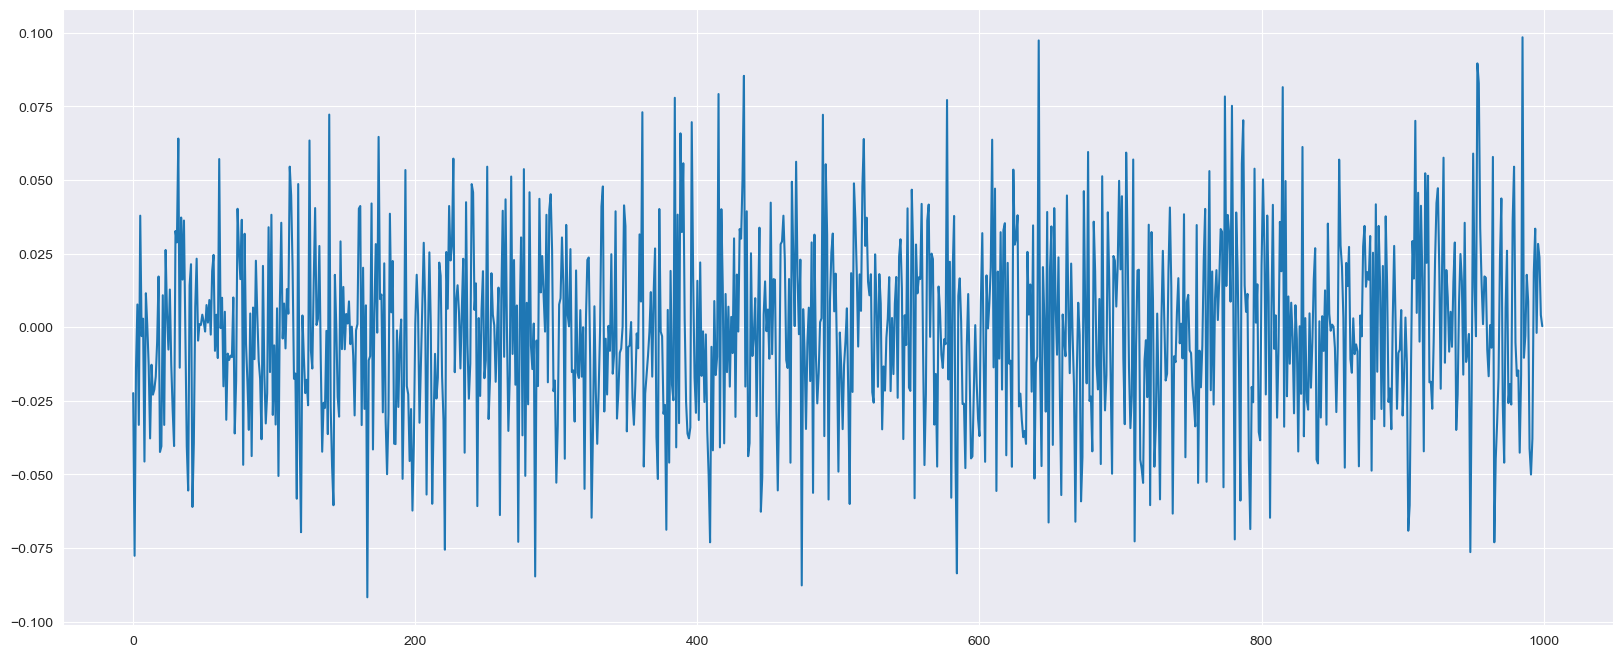

In [43]:
import math


def gen_white_noise(length, coef):
    mean = 0
    std = 1
    return np.random.normal(mean, std * coef, size=length)
plt.figure(figsize=(20, 8))
noise = gen_white_noise(1000, 0.03)
plt.plot(noise)
print(math.sqrt(0.03))

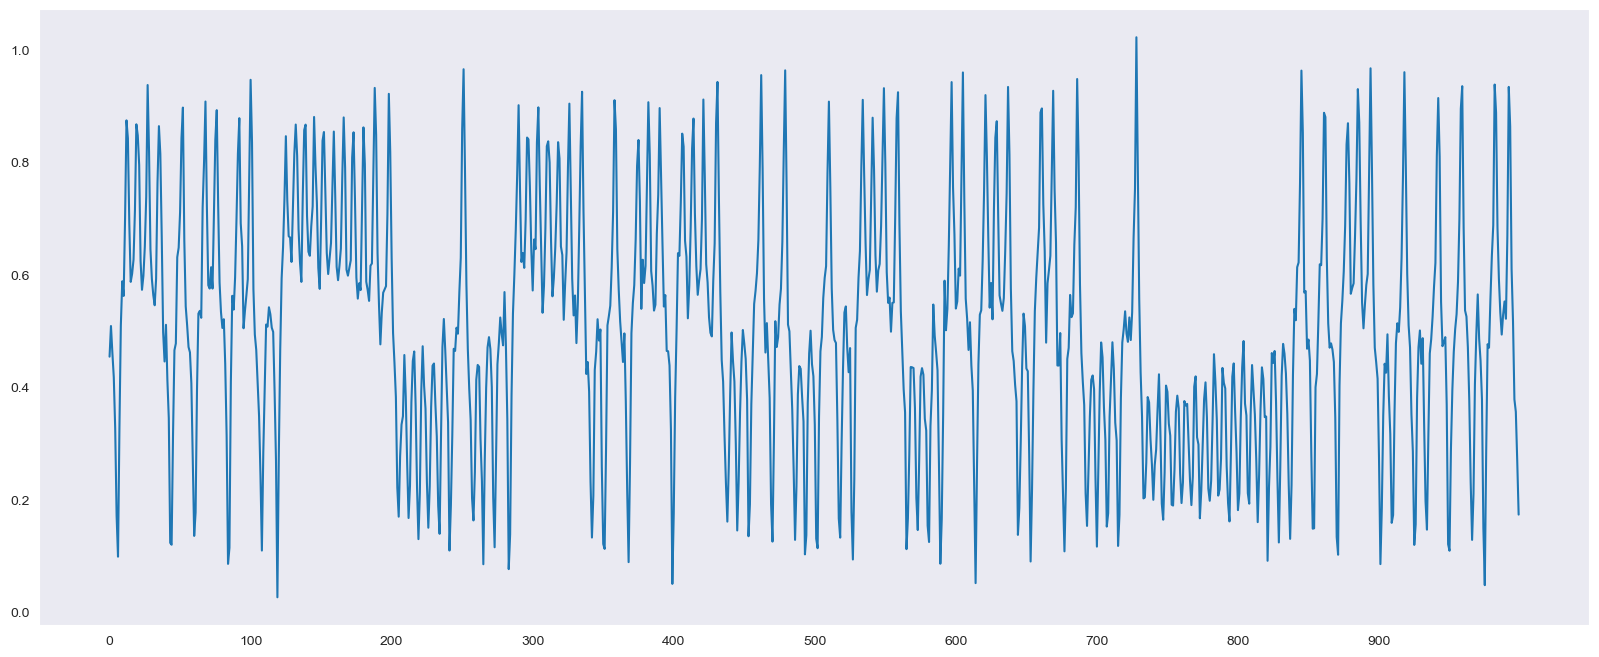

In [44]:
noisy_data = data + gen_white_noise(len(data), 0.03)
plt.figure(figsize=(20, 8))
plt.plot(noisy_data[:1000])
plt.xticks([i for i in range(0, 1000, 100)])
plt.grid()
plt.show()

In [36]:
data_c = np.load('../centers.npy', allow_pickle=True)
centers = dict()
for key, val in data_c:
    centers[key] = val

print(len(centers[(1, 1, 1)]))


252


In [37]:
from motifs.motifs import GenerateAllMotifs
WISHART_R = 10
WISHART_U = 0.2

class IdealDeamon(object):
    def __init__(self, real_vals, eps=0.05, mode='simple'):
        self.eps = eps
        self.mode = mode
        self.real_vals=real_vals
        # self.predictions = po

    @property
    def label(self):
        return 'Ideal model of demon'

    def predict(self, start_point, step, prediction):
        if abs(prediction - self.real_vals[start_point + step]) > self.eps:
            return None
        return prediction

    def is_predictable(self, start_point, step, prediction):
        return abs(prediction - self.real_vals[start_point + step]) <= self.eps

class Daemon:
    def __init__(self, mode="simple", is_pred=True, quantiles=(0, 1), gap=0.05):
        self.mode = mode
        self.is_pred = is_pred
        self.quantiles = quantiles
        self.gap = gap

    def mean_d(self, preds):
        sum_weight = sum(map(lambda x: x[1], preds))
        s = sum(map(lambda x: x[0] * x[1], preds))
        return s / sum_weight

    def mean_q(self, preds):
        sum_weight = sum(map(lambda x: x[2], preds))
        s = sum(map(lambda x: x[0] * x[2], preds))
        return s / sum_weight

    def mean_d_q(self, preds):
        cleaned = []
        vals = np.array(preds)[:, 0]
        df = pd.DataFrame(vals)
        low = df[0].quantile(self.quantiles[0])
        high = df[0].quantile(self.quantiles[1])
        for elem in preds:
            if low <= elem[0] <= high:
                cleaned.append(elem)
        if len(cleaned) == 0:
            return None
        sum_weight = sum(map(lambda x: x[1] * x[2], cleaned))
        s = sum(map(lambda x: x[0] * x[1] * x[2], cleaned))
        return s / sum_weight


    def predict(self, possible_values):
        if self.is_pred and not self.is_predictable(possible_values):
            return None
        if self.mode == "simple":
            return np.mean(list(map(lambda x: x[0], possible_values)))
        elif self.mode == "simple_d":
            return self.mean_d(possible_values)
        elif self.mode == "simple_q":
            return self.mean_q(possible_values)
        else:
            return self.mean_d_q(possible_values)
        # return self.mean_q(self.possible_values)

    def is_predictable(self, possible_values):
        vals = np.array(possible_values)[:, 0]
        df = pd.DataFrame(vals)
        low = df[0].quantile(self.quantiles[0])
        high = df[0].quantile(self.quantiles[1])
        if high - low > self.gap:
            return False
        # wishart = wishart_lib.Wishart(WISHART_R, WISHART_U)
        # labels = (wishart.fit([[i[0]] for i in possible_values]))
        # print(labels)
        # if len(set(labels)) > 3:
        #     return False
        return True

from tqdm import tqdm

def get_val_for_pattern_and_pos(data: np.array, pattern: list, pos: int, bad):
    val = []
    sum = 0
    for i in range(len(pattern) - 1, -1, -1):
        sum += pattern[i]
        val.append(data[pos - sum])
        if bad[pos - sum]:
            return np.array([])
    val = val[::-1]
    return np.array(val)

def get_val_for_motifs(data: np.array, motif: list, bad):
    val = []
    for i in motif:
        val.append(data[i])
        if bad[i]:
            return np.array([])
    return np.array(val)

def base_prediction(data, daemon: Daemon, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1, QVALUE = 0.99,
                    return_possible_values=False):
    t = len(data)
    prediction = np.zeros(shape=(t + h, 2))
    bad = np.array([0 for i in range(t + h)])
    for i in range(t):
        prediction[i][0] = data[i]
        prediction[i][1] = 1
    possible_values = [[] for i in range(h)]

    steps = 0
    # with tqdm(total=h) as pbar:
    for i in range(h):
        # pbar.update(1)
        for pattern in GenPatterns(L - 1, kmax):
            val_for_pattern_with_q = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)
            if len(val_for_pattern_with_q) == 0:
                continue
            val_for_pattern = val_for_pattern_with_q[:, 0]
            val_q = val_for_pattern_with_q[:, 1]

            for c in centers[pattern]:
                if len(c) == 0:
                    continue
                steps += 1
                dist = np.linalg.norm(c[:-1] - val_for_pattern)
                if dist < eps:
                    weight_d = (eps - dist) / eps
                    weight_q = np.mean(val_q) * QVALUE
                    possible_values[i].append([c[-1], weight_d, weight_q])
                #   possible_values[i].append([c[-1], weight_d, weight_q])

        # vals = np.array(possible_values)[:, 0]
        # df = pd.DataFrame(vals)
        # low = df[0].quantile(0.1)
        # high = df[0].quantile(0.9)
        # clean_values = []
        # for val in possible_values:
        #     if low <= val[0] <= high:
        #         clean_values.append(val)
        if len(possible_values[i]):
            pred = daemon.predict(possible_values[i])
            prediction[t + i][1] = np.mean(list(map(lambda x: x[2], possible_values[i])))

            if pred is not None:
                prediction[t + i][0] = pred
            else:
                bad[t + i] = 1
                prediction[t + i][0] = 0
        else:
            bad[t + i] = 1
            prediction[t + i][0] = 0

        # print(prediction[t + i])
    if return_possible_values:
        return [prediction, bad, possible_values]
    return [prediction, bad]

def base_prediction_ideal(data, centers, daemon: Daemon, ideal_daemon: IdealDeamon, h: int, L: int = 3, kmax: int = 10, eps: float = 0.1, QVALUE = 0.99, return_possible_values=False):
    t = len(data)
    prediction = np.zeros(shape=(t + h, 2))
    bad = np.array([0 for i in range(t + h)])
    for i in range(t):
        prediction[i][0] = data[i]
        prediction[i][1] = 1
    possible_values = [[] for i in range(h)]

    steps = 0
    # with tqdm(total=h) as pbar:
    for i in range(h):
        # pbar.update(1)

        for pattern in GenPatterns(L - 1, kmax):
            val_for_pattern_with_q = get_val_for_pattern_and_pos(prediction, pattern, t + i, bad)

            if len(val_for_pattern_with_q) == 0:
                continue
            val_for_pattern = val_for_pattern_with_q[:, 0]
            val_q = val_for_pattern_with_q[:, 1]


            for c in centers[pattern]:
                if len(c) == 0:
                    continue
                steps += 1
                dist = np.linalg.norm(c[:-1] - val_for_pattern)
                if dist < eps:
                    weight_d = (eps - dist) / eps
                    weight_q = np.mean(val_q) * QVALUE
                    possible_values[i].append([c[-1], weight_d, weight_q])
                #   possible_values[i].append([c[-1], weight_d, weight_q])

        if len(possible_values[i]):
            pred = ideal_daemon.predict(0, i, daemon.predict(possible_values[i]))
            prediction[t + i][1] = np.mean(list(map(lambda x: x[2], possible_values[i])))

            if pred is not None:
                prediction[t + i][0] = pred
            else:
                bad[t + i] = 1
                prediction[t + i][0] = 0
        else:
            bad[t + i] = 1
            prediction[t + i][0] = 0

        # print(prediction[t + i])
    # print(steps)
    return [prediction, bad, possible_values]




In [38]:
def DrawIdealPredict(data, end_point, steps):
    prediction, bad, possible = base_prediction_ideal(data[:end_point], Daemon(mode="simple_d_q", is_pred=False), IdealDeamon(data[end_point:], 0.05), steps, L=4, eps=0.009, return_possible_values=True)

    # print(bad[-steps:])
    xs = []
    ys = []
    for i in range(len(possible)):
        for p in possible[i]:
            xs.append(i)
            ys.append(p[0])
        # print(np.array(possible[i])[:, 0])
    plt.axes().set_facecolor('black')
    plt.scatter(xs, ys, s=[7 for i in range(len(xs))], alpha=0.2, c='red')

    plt.figure(figsize=(18, 12))
    plt.plot(data[end_point: end_point + steps], 'b', label='Real Data')
    # print(bad[-steps:])

    predicted_data = prediction[-steps:, 0]
    for i in range(steps):
        if bad[-steps + i]:
            predicted_data[-steps + i] = float('nan')

    plt.plot(predicted_data, 'r', label='Prediction')
    plt.legend(loc='best', fontsize='20')

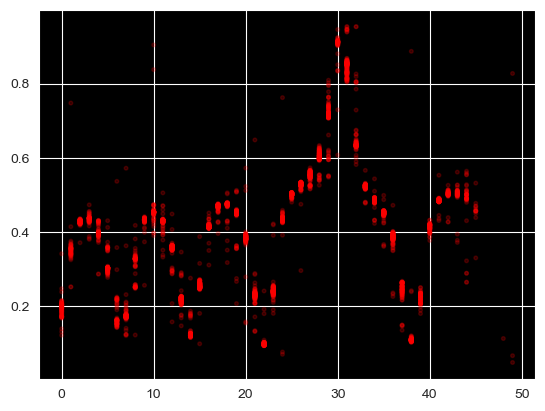

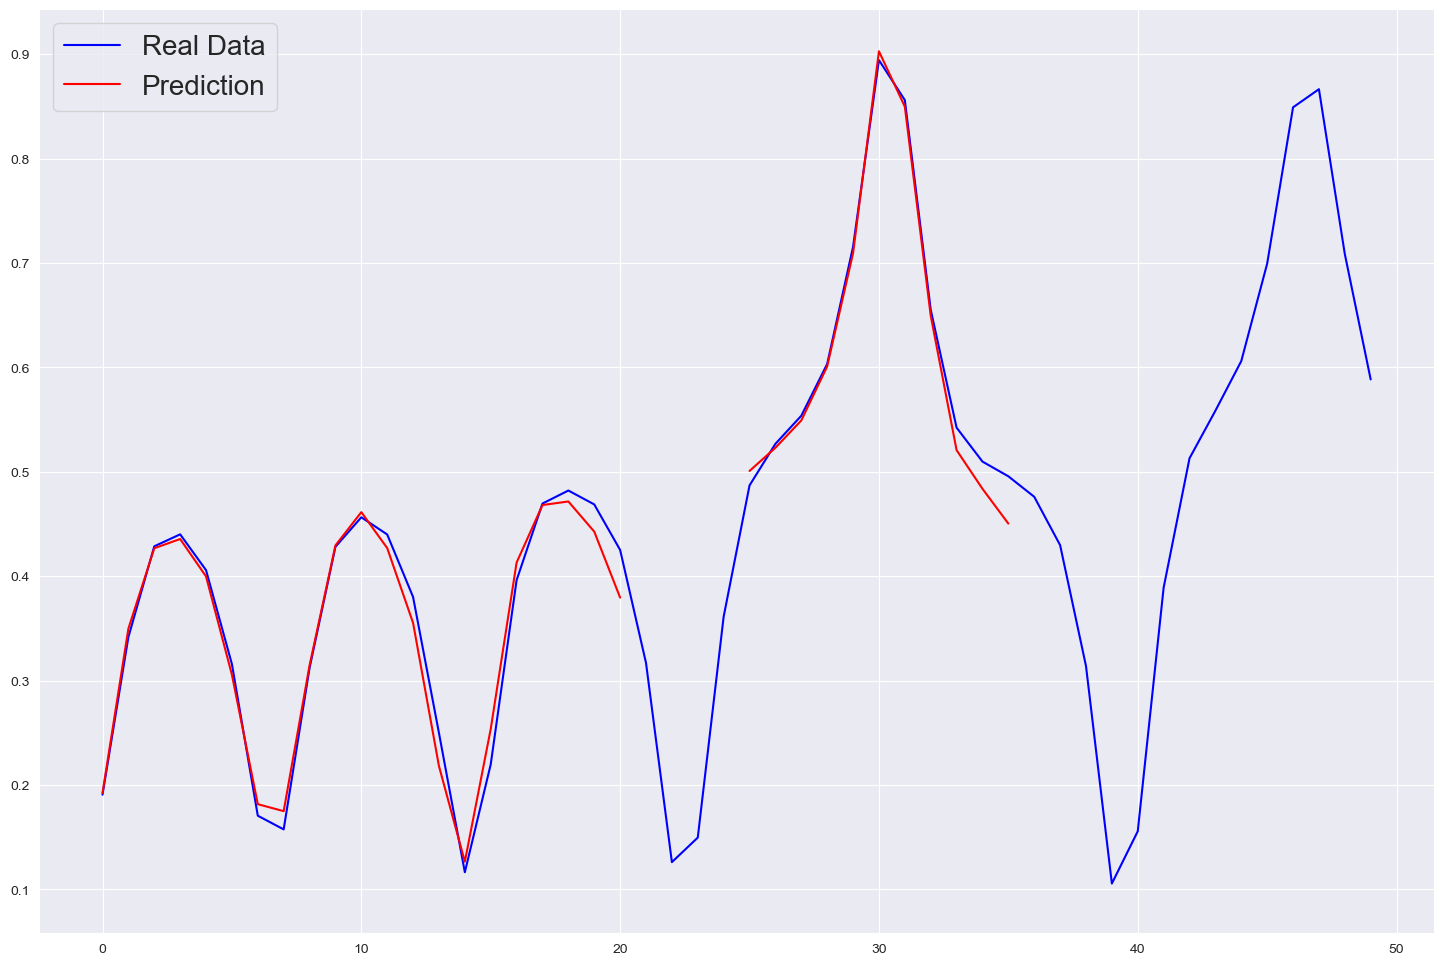

In [15]:
DrawIdealPredict(data, 10000, 50)

In [18]:
from scipy.interpolate import make_interp_spline
def CalculateStatsIdealDaemon(time_series, end_point, steps, count, daemon):
    end_points = []
    for i in range(count):
        end_points.append(end_point + random.randint(1, 1000))

    bad_count = [0] * steps
    good_count = [0] * steps
    err_sum = [0] * steps

    with tqdm(total=count) as pbar:
        for ending in end_points:
            prediction, bad, possible = base_prediction_ideal(time_series[:ending], daemon, IdealDeamon(time_series[ending:], 0.05), steps, L=4, eps=0.009, return_possible_values=True)

            for step in range(steps):
                if bad[-steps + step]:
                    bad_count[step] += 1
                else:
                    good_count[step] += 1
                    err_sum[step] += abs(prediction[-steps + step][0] - time_series[ending + step]) ** 2
            pbar.update(1)


    def get_amount_of_predictable_pts(dat, pref):
        return sum(dat[:pref]) / count / (pref + 1) * 100.0

    bad_percentage = [0] * steps
    for i in range(steps):
        bad_percentage[i] = get_amount_of_predictable_pts(bad_count, i)

    errs = [float('nan')] * steps
    for step in range(steps):
        if good_count[step] > 0:
            errs[step] = (err_sum[step] / good_count[step]) ** 0.5

    return bad_percentage, errs




In [90]:
import math

def smoothing(arr):
    x = np.array([i + 1 for i in range(len(arr))])
    y = np.array(arr)
    mx = 0
    for el in y:
        if not math.isnan(el):
            mx = max(mx, el)
    for i in range(len(y)):
        if math.isnan(y[i]):
            y[i] = mx
    spline = make_interp_spline(x, y)
    x = np.linspace(x.min(), x.max(), 500)
    y = spline(x)
    return x, y

def plot_non_predictable(bad_percentage, length):
    plt.figure(figsize=(9, 6))
    plt.title('Non predictable, %')
    for coef, stat in bad_percentage.items():
        x_, y_ = smoothing(stat[:length])
        plt.plot(x_, y_, label=str(coef))
    plt.xticks([y for y in range(0, length + 1, length // 10)])
    plt.yticks([y for y in range(0, 101, 10)])
    plt.legend(title='Noise coefficient')
    plt.xlabel('Steps')
    plt.ylabel('% of non predictable points')

def plot_error(errs, length, smooth=True):
    plt.figure(figsize=(9, 6))
    plt.title('RMSE')
    for coef, stat in errs.items():
        if smooth:
            x_, y_ = smoothing(stat[:length])
            plt.plot(x_, y_, label=str(coef))
        else:
            plt.plot(stat[:length], label=str(coef))
    plt.legend(title='Noise coefficient')
    plt.xticks([y for y in range(0, length + 1, length // 10)])
    plt.xlabel('Steps')
    plt.ylabel('Root mean square error')


In [53]:
classic_daemon = Daemon(mode="simple_d_q", is_pred=False)

In [56]:
import os

noisy_data = dict()
for coef in [0, 0.01, 0.02, 0.03]:
    noisy_data[coef] = data + gen_white_noise(len(data), coef)

stat_np = dict()
stat_err = dict()
for coef, time_series in noisy_data.items():
    filename = "ideal_results/noise_" + str(coef) + ".npy"
    if os.path.isfile(filename):
        print("loading for noise:", coef)
        stats = np.load(filename, allow_pickle=True)
        stat_np[coef], stat_err[coef] = stats[0], stats[1]
    else:
        print("regenerating for noise:", coef)
        stat_np[coef], stat_err[coef] = CalculateStatsIdealDaemon(time_series, 10000, 1000, 20, classic_daemon)
        stats = np.array([stat_np[coef], stat_err[coef]], dtype=object)
        np.save(filename, stats)

regenerating for noise: 0


100%|██████████| 20/20 [19:55<00:00, 59.78s/it]


regenerating for noise: 0.01


100%|██████████| 20/20 [10:46<00:00, 32.31s/it]


regenerating for noise: 0.02


100%|██████████| 20/20 [07:15<00:00, 21.77s/it]


regenerating for noise: 0.03


100%|██████████| 20/20 [06:10<00:00, 18.50s/it]


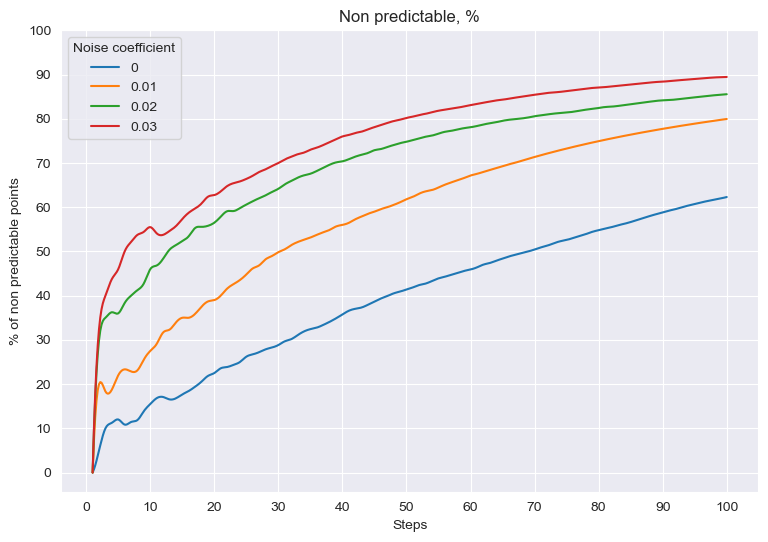

In [81]:
plot_non_predictable(stat_np, 100)

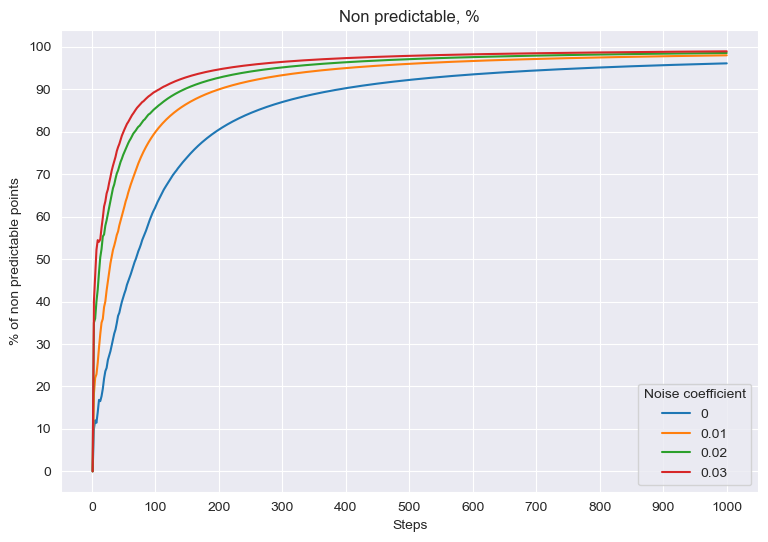

In [57]:
plot_non_predictable(stat_np, 1000)
# plot_error(stat_err)

In [82]:
def CalculateStatsDaemonApprox(time_series, end_point, steps, count, daemon):
    end_points = []
    for i in range(count):
        end_points.append(end_point + random.randint(1, 5000))

    bad_count = [0] * steps
    good_count = [0] * steps
    err_sum = [0] * steps

    with tqdm(total=count) as pbar:
        for ending in end_points:
            prediction, bad, possible = base_prediction(time_series[:ending], daemon, steps, L=4, eps=0.009, return_possible_values=True)

            for step in range(steps):
                if bad[-steps + step]:
                    bad_count[step] += 1
                else:
                    good_count[step] += 1
                    err_sum[step] += abs(prediction[-steps + step][0] - time_series[ending + step]) ** 2
            pbar.update(1)


    def get_amount_of_predictable_pts(dat, pref):
        return sum(dat[:pref]) / count / (pref + 1) * 100.0

    bad_percentage = [0] * steps
    for i in range(steps):
        bad_percentage[i] = get_amount_of_predictable_pts(bad_count, i)

    errs = [float('nan')] * steps
    for step in range(steps):
        if good_count[step] > 0:
            errs[step] = (err_sum[step] / good_count[step]) ** 0.5

    return bad_percentage, errs


In [83]:
gap_daemon = Daemon(mode="simple_d_q", is_pred=True, quantiles=(0.2, 0.8), gap=0.03)

In [85]:
stat_np_gap = dict()
stat_err_gap = dict()

for coef, time_series in noisy_data.items():
    filename = "gap_daemon_results_big/noise_" + str(coef) + ".npy"
    if os.path.isfile(filename):
        print("loading for noise:", coef)
        stats = np.load(filename, allow_pickle=True)
        stat_np_gap[coef], stat_err_gap[coef] = stats[0], stats[1]
    else:
        print("regenerating for noise:", coef)
        stat_np_gap[coef], stat_err_gap[coef] = \
            CalculateStatsDaemonApprox(time_series, 10000, 40, 200, gap_daemon)
        stats = np.array([stat_np[coef], stat_err[coef]], dtype=object)
        np.save(filename, stats)

regenerating for noise: 0


100%|██████████| 200/200 [1:42:47<00:00, 30.84s/it]


regenerating for noise: 0.01


100%|██████████| 200/200 [1:26:06<00:00, 25.83s/it]


regenerating for noise: 0.02


100%|██████████| 200/200 [43:11<00:00, 12.96s/it]


regenerating for noise: 0.03


100%|██████████| 200/200 [44:23<00:00, 13.32s/it]


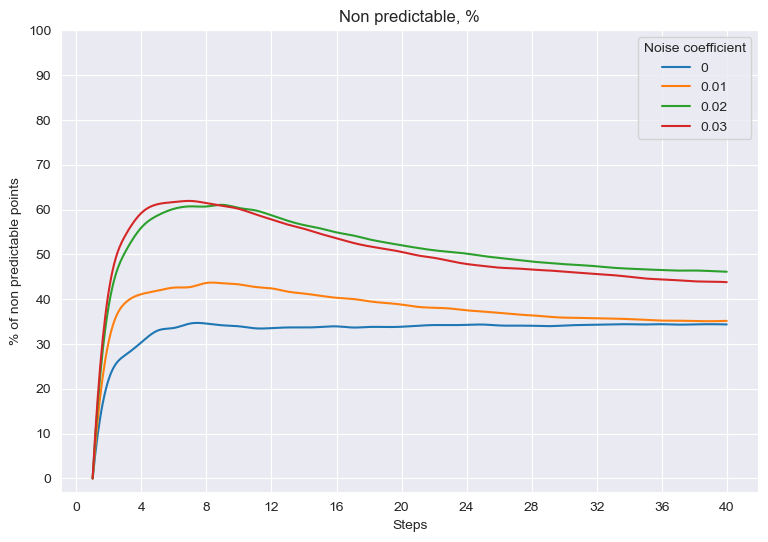

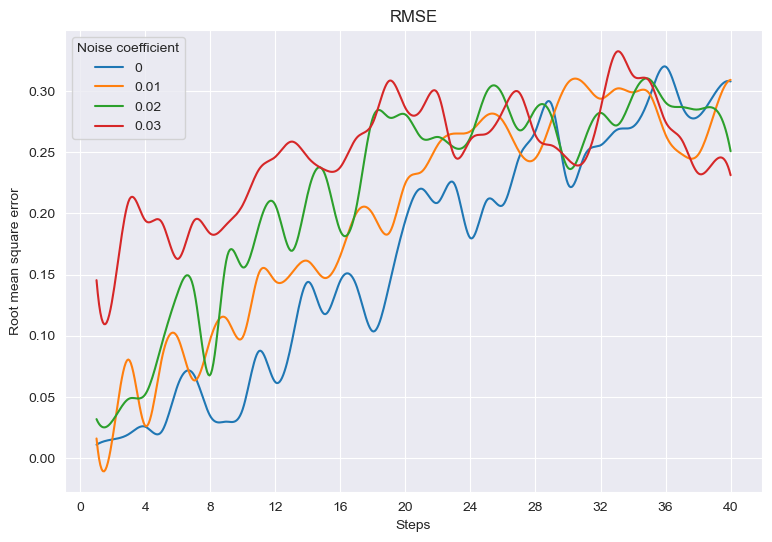

In [92]:
plot_non_predictable(stat_np_gap, 40)
plot_error(stat_err_gap, 40, True)

In [1]:
data_c = np.load('centers/centers_train_300_noise_0.npy', allow_pickle=True)
centers = dict()
for key, val in data_c:
    centers[key] = val

print(len(centers[(1, 1, 1)]))

NameError: name 'np' is not defined